In [1]:
import sys
sys.path.insert(0, '../')
from nn_cno import ode
import numpy as np
import itertools
import jax.numpy as jnp
import jax
import diffrax
import optax

In [2]:
# load the network 
c = ode.NNODE("../nn_cno/datasets/working_case_study/PKN-test.sif",
    "../nn_cno/datasets/working_case_study/MD-test.csv")

WARNING [absl:335]:  No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
WARNING [absl:335]:  No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
WARNING [absl:335]:  No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
c.preprocessing(expansion=False)

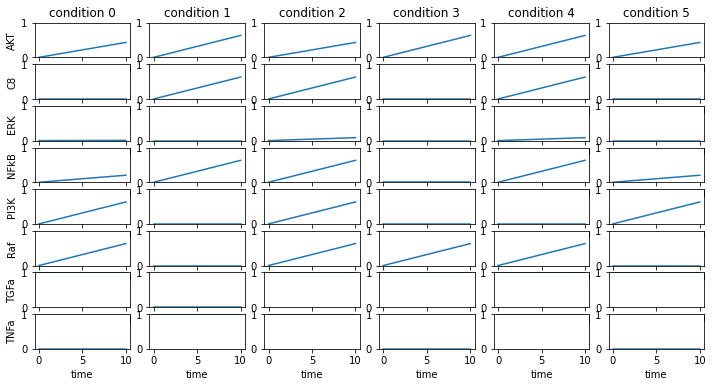

In [4]:
c.plot_simulation(c.simulate(stepsize_controller=diffrax.ConstantStepSize()))

Checking the gradient calculation through the multi-condition setup

In [5]:
# computes the gradient by central finite difference
# evaluates the loss function at p and measured_data
def cfd_grad_loss(model,p,dp=0.01):
    
    ref = p.copy()

    grad = np.zeros((len(p),))

    for i in range(len(p)):
        p_working_p = np.array(ref)
        p_working_n = np.array(ref)
        p_working_p[i] += dp/2
        p_working_n[i] -= dp/2
        forward = model.loss_function(jnp.array(p_working_p))
        backward = model.loss_function(jnp.array(p_working_n))
        grad[i] = (forward - backward) / (dp)
    return(grad)
    

In [6]:
pars = c.get_ODEparameters()
jax_pars = jnp.asarray(list(pars.values()))
grad = cfd_grad_loss(c,jax_pars)

In [7]:
grad

#cfd_grad_loss(c,pars)

array([-0.00836402, -0.00817031,  0.13481528,  0.        ,  0.        ,
       -0.16944855,  0.00378191,  0.00368059,  0.00365376,  0.00328124,
       -0.05428344, -0.0016287 , -0.00156462,  0.        ,  0.        ,
        0.09228885,  0.        ,  0.        ,  0.18647909,  0.        ,
        0.        , -0.06859154])

In [8]:
loss_value, grads = jax.value_and_grad(c.loss_function)(jax_pars)

In [9]:
grads

DeviceArray([-0.00836293, -0.00817067,  0.13509665,  0.        ,
              0.        , -0.1691665 ,  0.00378179,  0.00368012,
              0.00365477,  0.00328091, -0.05427588, -0.00162955,
             -0.00156496,  0.        ,  0.        ,  0.09245268,
              0.        ,  0.        ,  0.18656486,  0.        ,
              0.        , -0.06858799], dtype=float32)

In [10]:
abs(grad- grads) / (abs(grads)+1e-8)

DeviceArray([1.3085162e-04, 4.3997643e-05, 2.0827947e-03, 0.0000000e+00,
             0.0000000e+00, 1.6672872e-03, 3.4107652e-05, 1.2590113e-04,
             2.7482683e-04, 9.9563993e-05, 1.3933147e-04, 5.2236789e-04,
             2.1416406e-04, 0.0000000e+00, 0.0000000e+00, 1.7720503e-03,
             0.0000000e+00, 0.0000000e+00, 4.5973866e-04, 0.0000000e+00,
             0.0000000e+00, 5.1706953e-05], dtype=float32)

In [11]:
c.ODEparameters
loss_value, grads = jax.value_and_grad(c.loss_function)(jax_pars.at[1].set(0.01))
loss_value

DeviceArray(98010.16, dtype=float32)

In [12]:
opt_par = c.fit(params=jax_pars)

step 0, loss: 0.1511961668729782
	params: [1.0099999  2.01       0.09000007 1.         2.         0.10999993
 0.99000007 1.9900001  0.99000007 1.9900001  0.10999993 1.0099999
 2.0099998  1.         2.         0.09000007 1.         2.
 0.09000007 1.         2.         0.10999993]
step 10, loss: 0.1170337125658989
	params: [ 1.0930372   2.0984254   0.0677475   1.          2.          0.19703364
  0.88788944  1.887982    0.8915032   1.8949609   0.20725027  1.0765575
  2.0796342   1.0000834   2.          0.08717748  1.          2.
 -0.00253426  1.          2.          0.2032137 ]
step 20, loss: 0.10810359567403793
	params: [1.1308873  2.145422   0.07203323 1.         2.         0.2514174
 0.779795   1.7853216  0.79046917 1.8052882  0.30413726 1.0994068
 2.1037018  1.0005904  2.         0.13200858 1.         2.
 0.02946248 1.         2.         0.28788552]
step 30, loss: 0.10331027954816818
	params: [1.1680802  2.202446   0.06721077 1.         2.         0.28226146
 0.67114204 1.6919429  0.

In [13]:
opt_par

DeviceArray([1.5101496 , 2.73365   , 0.06890852, 1.        , 2.        ,
             0.3432446 , 0.02082833, 1.2093785 , 0.44593245, 1.6350206 ,
             0.62493426, 0.37679386, 1.3220628 , 1.0039171 , 2.0000012 ,
             0.04037173, 1.        , 2.        , 0.04971356, 1.        ,
             2.        , 0.4724739 ], dtype=float32)

In [14]:
c.fit(opt_par)

step 0, loss: 39.38475799560547
	params: [1.5201494  2.7436497  0.05890872 1.         2.         0.35324448
 0.01082839 1.2193784  0.43593296 1.6250646  0.6349341  0.38679367
 1.3320622  1.0041533  2.0000017  0.03037181 1.         2.
 0.03971363 1.         2.         0.48247364]
step 10, loss: 1.4963223934173584
	params: [1.5793619  2.8081641  0.06432291 1.         2.         0.44028485
 0.00715352 1.2863979  0.36113277 1.6280676  0.70404875 0.40373686
 1.3354479  1.0044576  2.0000021  0.03562383 1.         2.
 0.02235959 1.         2.         0.55490947]
step 20, loss: 2.3746728897094727
	params: [ 1.6295358   2.8724735   0.06721459  1.          2.          0.494686
 -0.00379243  1.344877    0.30359572  1.7091498   0.7575195   0.41255316
  1.3261255   1.0043905   2.0000021   0.035135    1.          2.
  0.0302926   1.          2.          0.60497904]
step 30, loss: 0.7441973686218262
	params: [1.6907670e+00 2.9520352e+00 6.9971040e-02 1.0000000e+00 2.0000000e+00
 5.2554780e-01 2.65399

DeviceArray([1.7731512e+00, 3.0891593e+00, 6.9356568e-02, 1.0000000e+00,
             2.0000000e+00, 5.8659708e-01, 9.1102213e-04, 1.5587085e+00,
             1.7555922e-01, 2.0830715e+00, 9.0829223e-01, 5.0214970e-01,
             1.3340333e+00, 1.0041474e+00, 2.0000021e+00, 4.0415883e-02,
             1.0000000e+00, 2.0000000e+00, 8.1498073e-03, 1.0000000e+00,
             2.0000000e+00, 6.7637640e-01], dtype=float32)

In [15]:
c.loss_function(opt_par)

DeviceArray(39.384758, dtype=float32)

In [16]:
c.loss_function(opt_par)

DeviceArray(39.384758, dtype=float32)

In [17]:
my_params =  [ 1.0930372,   2.0984254,   0.0677475,   1. ,         2.,          0.19703364,
  0.88788944,  1.887982,    0.8915032,   1.8949609,   0.20725027,  1.0765575,
  2.0796342,   1.0000834,   2.,          0.08717748 , 1.,          2.,
 -0.00253426,  1. ,         2.,          0.2032137 ]

my_params = [1.1498164e+00,  2.1650469e+00,  6.9093235e-02,  1.0000000e+00,
  2.0000000e+00,  3.3968520e-01, -1.7079073e-03,  1.4293289e+00,
  4.6056718e-01,  1.6366247e+00,  5.8773327e-01,  1.1140659e+00,
  2.1182714e+00,  1.0000780e+00,  2.0000000e+00,  4.0923573e-02,
  1.0000000e+00,  2.0000000e+00, -7.7298731e-02,  1.0000000e+00,
  2.0000000e+00,  4.6674308e-01]

clipped_my_param = [1.1498164e+00, 2.1650469e+00, 6.9093235e-02, 1.0000000e+00,
             2.0000000e+00, 3.3968520e-01, 0.0000000e+00, 1.4293289e+00,
             4.6056718e-01, 1.6366247e+00, 5.8773327e-01, 1.1140659e+00,
             2.1182714e+00, 1.0000780e+00, 2.0000000e+00, 4.0923573e-02,
             1.0000000e+00, 2.0000000e+00, 1.0000000e-03, 1.0000000e+00,
             2.0000000e+00, 4.6674308e-01]



In [18]:
c.loss_function(params=jnp.asarray(my_params))

DeviceArray(6130691.5, dtype=float32)

In [19]:
list(c.ODEparameters.keys())[1]

'PI3K_n_AKT'

In [20]:
par_dict = c.ODEparameters.copy()
for i in range(len(clipped_my_param)):
    par_dict[list(c.ODEparameters.keys())[i]] = clipped_my_param[i]
par_dict

{'PI3K_k_AKT': 1.1498164,
 'PI3K_n_AKT': 2.1650469,
 'tau_AKT': 0.069093235,
 'TNFa_k_C8': 1.0,
 'TNFa_n_C8': 2.0,
 'tau_C8': 0.3396852,
 'NFkB_k_ERK': 0.0,
 'NFkB_n_ERK': 1.4293289,
 'Raf_k_ERK': 0.46056718,
 'Raf_n_ERK': 1.6366247,
 'tau_ERK': 0.58773327,
 'PI3K_k_NFkB': 1.1140659,
 'PI3K_n_NFkB': 2.1182714,
 'TNFa_k_NFkB': 1.000078,
 'TNFa_n_NFkB': 2.0,
 'tau_NFkB': 0.040923573,
 'TGFa_k_PI3K': 1.0,
 'TGFa_n_PI3K': 2.0,
 'tau_PI3K': 0.001,
 'TGFa_k_Raf': 1.0,
 'TGFa_n_Raf': 2.0,
 'tau_Raf': 0.46674308}

In [21]:
c.symbolicODE["eqns"][2].subs("tau_ERK",0.1).subs("ERK",0.0).subs("Raf",0.0).subs("NFkB",0.0).subs("NFkB_n_ERK",1.4293289).subs("Raf_n_ERK",1.6366247)

0

In [22]:
c.symbolicODE["eqns"][2]

tau_ERK*(-ERK + NFkB**NFkB_n_ERK*Raf**Raf_n_ERK*(NFkB_k_ERK**NFkB_n_ERK + 1)*(Raf_k_ERK**Raf_n_ERK + 1)/((NFkB**NFkB_n_ERK + NFkB_k_ERK**NFkB_n_ERK)*(Raf**Raf_n_ERK + Raf_k_ERK**Raf_n_ERK)))

In [23]:
args = dict(model_parameters = clipped_my_param,
            condition = c.conditions[0],
            states = c.states)

c.sim_function(0,jnp.array(list(c.conditions[0]["y0"].values())),args)

DeviceArray([0.06909323, 0.        ,        nan, 0.        , 0.001     ,
             0.46674308, 0.        , 0.        ], dtype=float32)

In [24]:

optimizer = optax.adam(learning_rate=1e-2)
params = jax_pars.copy()
opt_state = optimizer.init(params)
def step(params, opt_state):
    loss_value, grads = jax.value_and_grad(c.loss_function)(params)

    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value

In [25]:
loss_value, grads = jax.value_and_grad(c.loss_function)(params)

In [26]:
updates, opt_state = optimizer.update(grads, opt_state, params)
params = optax.apply_updates(params, updates)
print(params)

[1.0099999  2.01       0.09000007 1.         2.         0.10999993
 0.99000007 1.9900001  0.99000007 1.9900001  0.10999993 1.0099999
 2.0099998  1.         2.         0.09000007 1.         2.
 0.09000007 1.         2.         0.10999993]


In [43]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

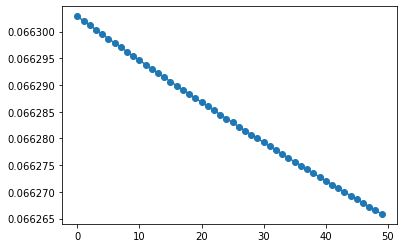

In [48]:

convergence = list()
steps = list()

fig = plt.figure()
axs = fig.add_subplot(1,1,1)


for i in range(50):
    params, opt_state, loss_value = step(params, opt_state)
    convergence.append(loss_value)
    steps.append(i)

    axs.set_xlim(0,i)
    axs.cla()
    axs.plot(steps,convergence, marker = "o")
    display(fig)
    clear_output(wait=True)
    

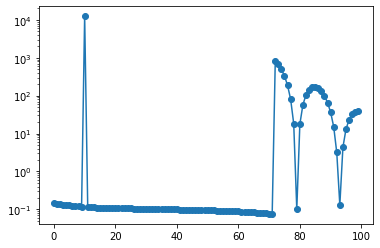

In [37]:
fig = plt.figure()
axs = fig.add_subplot(111)
axs.plot(steps,convergence, marker = "o")
plt.yscale("log")
plt.show()

In [33]:
convergence

[DeviceArray(0.14432223, dtype=float32),
 DeviceArray(0.13863182, dtype=float32),
 DeviceArray(0.1342572, dtype=float32),
 DeviceArray(0.13116561, dtype=float32),
 DeviceArray(0.12890281, dtype=float32),
 DeviceArray(0.12672783, dtype=float32),
 DeviceArray(0.12426808, dtype=float32),
 DeviceArray(0.12165114, dtype=float32),
 DeviceArray(0.11916252, dtype=float32),
 DeviceArray(0.11703371, dtype=float32),
 DeviceArray(12491.137, dtype=float32),
 DeviceArray(0.11397619, dtype=float32),
 DeviceArray(0.11287469, dtype=float32),
 DeviceArray(0.11197824, dtype=float32),
 DeviceArray(0.11121259, dtype=float32),
 DeviceArray(0.11052332, dtype=float32),
 DeviceArray(0.1098772, dtype=float32),
 DeviceArray(0.10925893, dtype=float32),
 DeviceArray(0.10866605, dtype=float32),
 DeviceArray(0.1081036, dtype=float32),
 DeviceArray(0.10757864, dtype=float32),
 DeviceArray(0.10709437, dtype=float32),
 DeviceArray(0.10664523, dtype=float32),
 DeviceArray(0.10621507, dtype=float32),
 DeviceArray(0.10578

In [ ]:
from functools import partial

In [ ]:
@partial(jax.jit, static_argnums=(0))
def simulate_condition(ind, c, stepsize_controller, parameters, ODEsolver, ODEterm, states):
    # run the simulation in a specific condition
    user_data = dict(model_parameters = parameters,
            condition = c[ind],
            states = states
            )
    t0 = c["time"][0]
    t1 = c["time"][-1]
    y0 = jnp.array(list(c["y0"].values()))
    ts = c["time"]
        
    sim_condition = diffrax.diffeqsolve(ODEterm, ODEsolver,
                    t0=t0, t1=t1, dt0=0.1,
                    y0=y0,
                    args = user_data, 
                    saveat=diffrax.SaveAt(ts=ts),
                    stepsize_controller = stepsize_controller)
                
    return sim_condition

In [ ]:
jax.vmap(simulate_condition, in_axes = (0,), out_axes=(0))(jnp.array(range(len(c.conditions))), tuple(c.conditions),diffrax.ConstantStepSize(),jax_pars,diffrax.Heun(),c._diffrax_ODEterm ,c.states)

ValueError: vmap in_axes specification must be a tree prefix of the corresponding value, got specification (0,) for value tree PyTreeDef((*, ({'inhibited': [], 'measured': [*, *, *, *], 'stimulated': [*], 'time': [*, *], 'y0': {'AKT': *, 'C8': *, 'ERK': *, 'NFkB': *, 'PI3K': *, 'Raf': *, 'TGFa': *, 'TNFa': *}}, {'inhibited': [], 'measured': [*, *, *, *], 'stimulated': [*], 'time': [*, *], 'y0': {'AKT': *, 'C8': *, 'ERK': *, 'NFkB': *, 'PI3K': *, 'Raf': *, 'TGFa': *, 'TNFa': *}}, {'inhibited': [], 'measured': [*, *, *, *], 'stimulated': [*, *], 'time': [*, *], 'y0': {'AKT': *, 'C8': *, 'ERK': *, 'NFkB': *, 'PI3K': *, 'Raf': *, 'TGFa': *, 'TNFa': *}}, {'inhibited': [*], 'measured': [*, *, *, *], 'stimulated': [*], 'time': [*, *], 'y0': {'AKT': *, 'C8': *, 'ERK': *, 'NFkB': *, 'PI3K': *, 'Raf': *, 'TGFa': *, 'TNFa': *}}, {'inhibited': [*], 'measured': [*, *, *, *], 'stimulated': [*, *], 'time': [*, *], 'y0': {'AKT': *, 'C8': *, 'ERK': *, 'NFkB': *, 'PI3K': *, 'Raf': *, 'TGFa': *, 'TNFa': *}}, {'inhibited': [*], 'measured': [*, *, *, *], 'stimulated': [*], 'time': [*, *], 'y0': {'AKT': *, 'C8': *, 'ERK': *, 'NFkB': *, 'PI3K': *, 'Raf': *, 'TGFa': *, 'TNFa': *}}), CustomNode(<class 'diffrax.step_size_controller.constant.ConstantStepSize'>[(('compile_steps',), (), ())], [*]), *, CustomNode(<class 'diffrax.solver.heun.Heun'>[((), (), ())], []), CustomNode(<class 'diffrax.term.ODETerm'>[(('vector_field',), (), ())], [*]), (*, *, *, *, *, *, *, *))).

In [ ]:

simulate_condition(c.conditions[1],diffrax.ConstantStepSize(),jax_pars,diffrax.Heun(),c._diffrax_ODEterm ,c.states)


Solution(
  t0=f32[],
  t1=f32[],
  ts=f32[2],
  ys=f32[2,8],
  interpolation=None,
  stats={
    'compiled_num_steps':
    None,
    'max_steps':
    4096,
    'num_accepted_steps':
    i32[],
    'num_rejected_steps':
    i32[],
    'num_steps':
    i32[]
  },
  result=i32[],
  solver_state=None,
  controller_state=None,
  made_jump=None
)